In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# Load datasets
df_train = pd.read_csv("../resources/df_train_preprocessed.csv")
df_validation = pd.read_csv("../resources/df_val_preprocessed.csv")
df_test = pd.read_csv("../resources/df_test_preprocessed.csv")

# Load vectorizer
vectorizer = joblib.load("../artifacts/vectorizer.joblib")

# Load trained model
best_model = joblib.load("../artifacts/model.joblib")


### 📂 Load Preprocessed Data and Artifacts

In this step, we load the preprocessed datasets (`train`, `validation`, `test`) and the artifacts generated from the preprocessing and training stages:  

- **Datasets**:  
  - `df_train_preprocessed.csv` → Training data  
  - `df_val_preprocessed.csv` → Validation data  
  - `df_test_preprocessed.csv` → Test data  

- **Artifacts**:  
  - `vectorizer.joblib` → Pre-trained TF-IDF vectorizer  
  - `model.joblib` → Best trained classification model  

These will be used to perform evaluation and final testing.


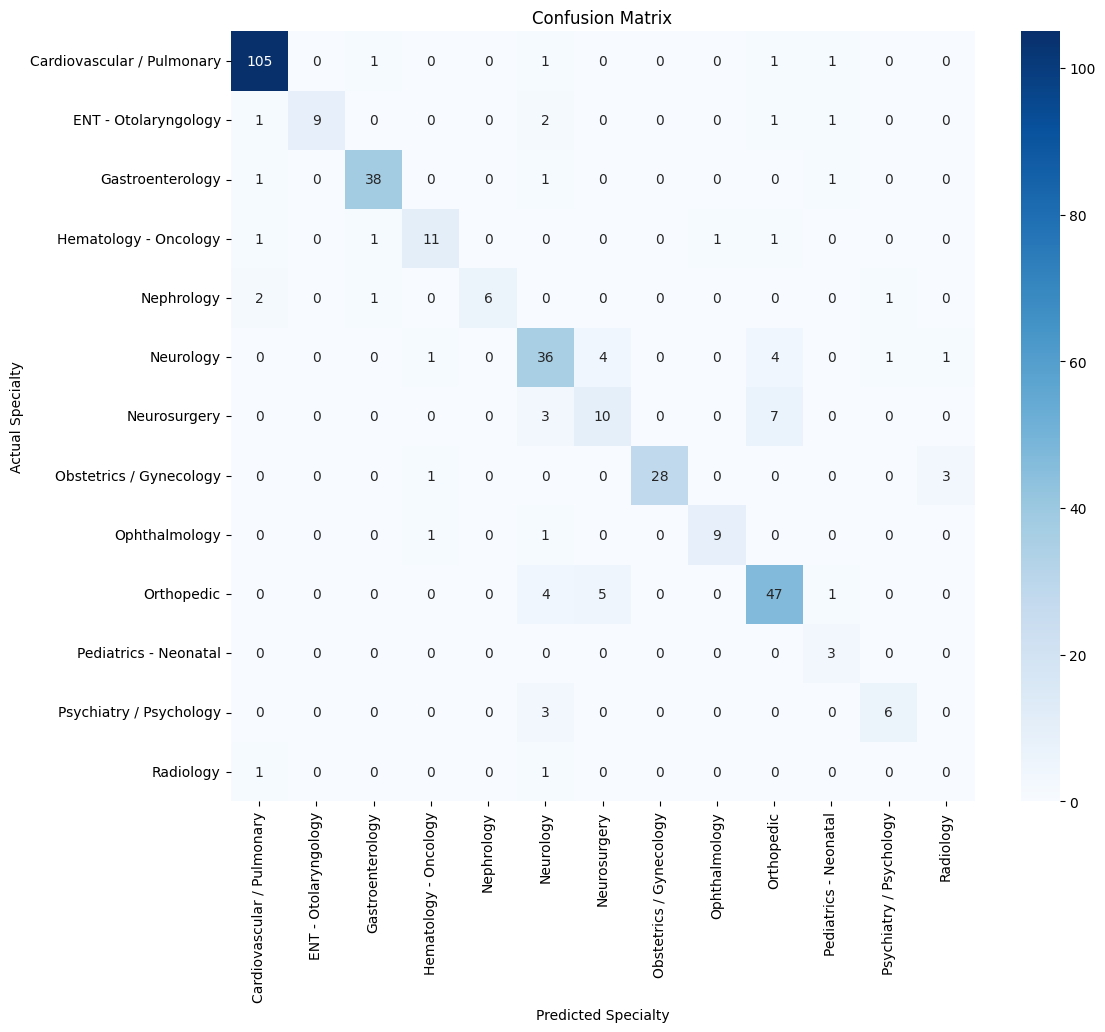

In [3]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = best_model.predict(df_test['combined_text'])
y_test_true = df_test['medical_specialty']

cm = confusion_matrix(y_test_true, y_test_pred, labels=best_model.classes_)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.ylabel("Actual Specialty")
plt.xlabel("Predicted Specialty")
plt.title("Confusion Matrix")
plt.show()

### 📊 Model Evaluation: Confusion Matrix & Classification Report

To further analyze the performance of the best model, we evaluate its predictions on the **test set**.  

- **Predictions**: Generate predicted labels for the test dataset.  
- **Confusion Matrix**: Visualize correct vs. incorrect classifications across all specialties.  
- **Classification Report**: Inspect precision, recall, and F1-score for each class.  

> 🔎 After testing all three models, this configuration produced the **most promising results**, especially in correctly predicting **Orthopedic, Neurology, and Neurosurgery** cases — which were among the most challenging and important classes in the dataset.


In [4]:
report = classification_report(y_test_true, y_test_pred, target_names=best_model.classes_)
print("📄 Classification Report:\n", report)

📄 Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.95      0.96      0.95       109
      ENT - Otolaryngology       1.00      0.64      0.78        14
          Gastroenterology       0.93      0.93      0.93        41
     Hematology - Oncology       0.79      0.73      0.76        15
                Nephrology       1.00      0.60      0.75        10
                 Neurology       0.69      0.77      0.73        47
              Neurosurgery       0.53      0.50      0.51        20
   Obstetrics / Gynecology       1.00      0.88      0.93        32
             Ophthalmology       0.90      0.82      0.86        11
                Orthopedic       0.77      0.82      0.80        57
     Pediatrics - Neonatal       0.43      1.00      0.60         3
   Psychiatry / Psychology       0.75      0.67      0.71         9
                 Radiology       0.00      0.00      0.00         2

                  ac


> ✅ **Key Insights:**  
> - The model achieved an overall **accuracy of 83%** on the test set.  
> - Strong results in **Cardiovascular / Pulmonary (0.95 F1)** and **Gastroenterology (0.93 F1)**.  
> - Promising improvements in **Orthopedic (0.80 F1)**, **Neurology (0.73 F1)**, and **Neurosurgery (0.51 F1)**, confirming better handling of these specialties compared to other models tested.  
> - Some specialties with very few samples (e.g., Radiology, Pediatrics - Neonatal) remain difficult for the model to predict accurately.  


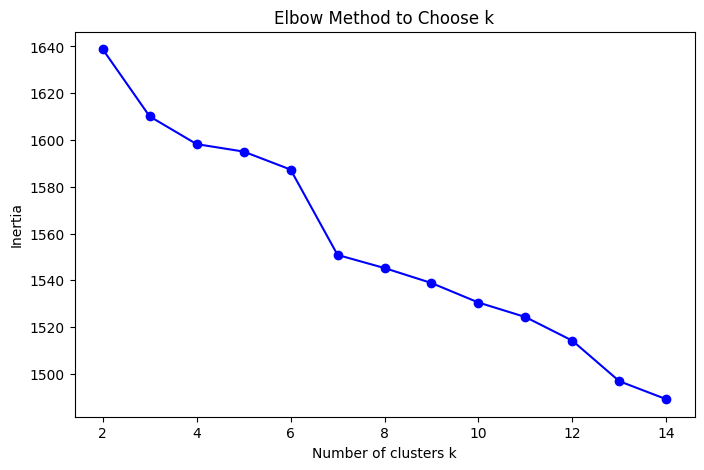

Cluster 0: nan, history, patient, nan nan, pain, report, past, year, time, normal
Cluster 1: artery, coronary, coronary artery, catheterization, angiography, pulmonary, catheter, right, stenosis, femoral
Cluster 2: pulmonary, atrial, cardiovascular pulmonary, valve, stress, cardiovascular, heart, chest, aortic, ventricular
Cluster 3: lobe, brain, tumor, pulmonary, mri, neurology, right, fetal, unremarkable, bronchoscopy
Cluster 4: lumbar, l5, l4, disc, l4 l5, disk, root, spinal, s1, l5 s1
Cluster 5: cervical, anterior, patient, discectomy, c5, c6, fracture, orthopedic, place, c4
Cluster 6: sample reports, reports, sample, medical transcription, transcription sample, transcription, orplace real, purely incidental, purpose mthelpline, andare reference
Cluster 7: knee, carpal, ligament, tunnel, tendon, carpal tunnel, medial, orthopedic, patella, meniscus
Cluster 8: history, nan, nan nan, patient, mg, daily, deny, past, pain, disease
Cluster 9: gastroenterology, laparoscopic, colon, abdome

In [5]:

X_tfidf = vectorizer.fit_transform(df_train['combined_text'])

inertia = []
K = range(2, 15)  # try 2–15 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Method to Choose k")
plt.show()

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_tfidf)

# Cluster labels for each document
clusters = kmeans.labels_
df_train['cluster'] = clusters

terms = vectorizer.get_feature_names_out()

for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    top_idx = cluster_center.argsort()[-10:][::-1]  # top 10 words
    top_terms = [terms[ind] for ind in top_idx]
    print(f"Cluster {i}: {', '.join(top_terms)}")

## 🔍 K-Means Clustering on Medical Text Data

We applied **K-Means clustering** to group medical transcripts into unsupervised clusters, aiming to uncover natural groupings of text data.

### 📌 Step 1: Elbow Method for Choosing `k`

We tested values of **k = 2 to 15** and plotted the **inertia** (sum of squared distances of samples to their closest cluster center).  
The "elbow point" in the graph helps identify an optimal number of clusters.

📊 **Elbow Method Plot:**

*(Generated by the code cell above)*

---

### 📌 Step 2: Train Final K-Means Model

Based on the elbow curve, we chose **k = 10** and trained the K-Means model on the TF-IDF representations of the training set.

- Each document was assigned to one of the 10 clusters.  
- The training dataframe was updated with a new column: **`cluster`**.

---

### 📌 Step 3: Top Terms per Cluster

The table above lists the **top 10 representative words** for each cluster, extracted from the cluster centroids:

